## Notebook for running single training and compare them

Imports and set seed optionally:

In [1]:
import torch
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


from layer_insertion_loop import layer_insertion_loop
from train_and_test_ import train, check_testerror
from nets import feed_forward, two_weight_resnet, one_weight_resnet
from utils import ema

h=3
random.seed(h)
np.random.seed(h)
torch.manual_seed(h)

torch.set_num_threads(8)

Define and list hyperparameters:

In [2]:
no_hidden_layers_start = 2
fix_width = 50
no_iters = 1
lr_decrease_after_li =1.#0.8
epochs = [1,2]
wanted_testerror = .5
_type = 'fwd'
act_fun = nn.ReLU
interval_testerror = 1

batch_size = 50 #1000 #20 #200 # 60000 for full batch
save_grad_norms = True

lr_init = 1e-1
optimizer_type = 'SGD'
lrscheduler_type = 'StepLR'
lrscheduler_args = {'step_size': 100,
                    'gamma': 0.1}


# for classical 
epochs_classical = sum(epochs)
lr_init_classical = lr_init
lrscheduler_args_classical = {'step_size': 100,
                    'gamma': 0.1}

Load dataset:

In [3]:
MNIST = True
FMNIST = False
CIFAR10 = False

In [4]:
if MNIST:    
    # Download training data from open datasets.
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

    tr_split_len = 60000#10000
    te_split_len = 10000#int(0.33*tr_split_len)
    training_data = torch.utils.data.random_split(training_data, [tr_split_len, len(training_data)-tr_split_len])[0]
    test_data = torch.utils.data.random_split(test_data, [te_split_len, len(test_data)-te_split_len])[0]

if FMNIST:
    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

if CIFAR10:
    # Download training data from open datasets.
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

In [5]:
print('no of iterations in one epoch:',int(len(training_data)/batch_size))
print(len(training_data))
print(len(test_data))

no of iterations in one epoch: 1200
60000
10000


Create dataloader:

In [6]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=10000)

Build models:

In [7]:
kwargs_net ={
        'hidden_layers': no_hidden_layers_start,
        'dim_hidden_layers': fix_width,
        'act_fun': act_fun,
        'type': _type
}

dim_in = 28*28 #32*32 
dim_out = 10

In [8]:
# classical net
kwargs_net_classical = {
    'hidden_layers': 2,
    'dim_hidden_layers': fix_width,
    'act_fun': act_fun,
    'type': _type
}

Determine which trainings are run:

In [9]:
T1 = True
T2 = True
T3 = True

## Training with layer insertion:

In [10]:
# build model
if _type=='fwd':
    model_init = feed_forward(dim_in, dim_out,**kwargs_net)
if _type=='res2':
    model_init = two_weight_resnet(dim_in, dim_out,**kwargs_net)
if _type=='res1':
    model_init = one_weight_resnet(dim_in, dim_out,**kwargs_net)

param_init = torch.nn.utils.parameters_to_vector(model_init.parameters())
param_init = copy.deepcopy(param_init.data)
param_init_class = copy.deepcopy(param_init.data)

Check initial test error of the model

In [11]:
print(check_testerror(test_dataloader,model_init))
print(check_testerror(train_dataloader,model_init))

88.16
88.17166666666667


In [12]:
# train ali 1
if T1:
    model1, mb_losses1, test_errors_short1, test_errors1, exit_flag1, grad_norms1 = layer_insertion_loop(
        iters=no_iters,
        epochs=epochs,
        model= model_init,
        kwargs_net=kwargs_net,
        dim_in=dim_in,
        dim_out=dim_out,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        lr_init=lr_init,
        wanted_test_error=wanted_testerror,
        mode='abs max',
        optimizer_type=optimizer_type,
        lrschedule_type=lrscheduler_type,
        lrscheduler_args=lrscheduler_args,
        check_testerror_between=interval_testerror,
        decrease_after_li=lr_decrease_after_li,
        print_param_flag=False,
        start_with_backtracking=None,
        v2=False,
        save_grad_norms=save_grad_norms
    ) 

starting on 1. net !
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=10, bias=True)
)
tensor(0.0773)
mbloss:  2.2905359268188477
tensor(0.1295)
tensor(0.0990)
tensor(0.0902)
tensor(0.1200)
tensor(0.0701)
tensor(0.1025)
tensor(0.1069)
tensor(0.0980)
tensor(0.1364)
tensor(0.1314)
tensor(0.1496)
tensor(0.0994)
tensor(0.1222)
tensor(0.1336)
tensor(0.1684)
tensor(0.1538)
tensor(0.1523)
tensor(0.1282)
tensor(0.1953)
tensor(0.1659)
tensor(0.1800)
tensor(0.1550)
tensor(0.1412)
tensor(0.1603)
tensor(0.1862)
tensor(0.2484)
tensor(0.1984)
tensor(0.1737)
tensor(0.2423)
tensor(0.3495)
tensor(0.2141)
tensor(0.1938)
tensor(0.3143)
tensor(0.3034)
tensor(0.4705)
tensor(0.2643)
tensor(0.3130)
tensor(0.2813)
tensor(0.3315)
tensor(0.2709)
tensor(0.4977)
tensor(0.2775)
tensor(0.4050)
tensor(0.3625)
tensor(0.8357)
tens

In [13]:
print('test error: ',check_testerror(test_dataloader, model1))
print('train error: ',check_testerror(train_dataloader, model1))

test error:  3.75
train error:  3.0416666666666714


plot results:

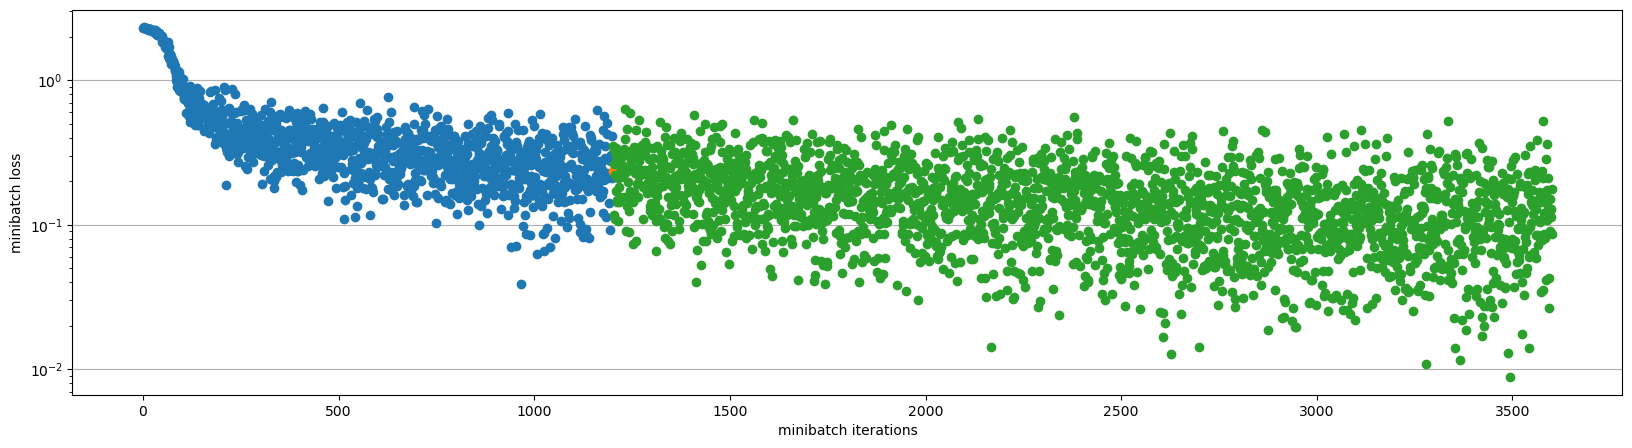

In [14]:
end_list=[]
for i,e in enumerate(epochs):
    end_list.append(int(e*len(training_data)/batch_size))
    end_list.append(1) 
end_list.pop() # removes last 1 which was too much

# todo plot
if T1:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(mb_losses1)+1)
    yfull = mb_losses1
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('minibatch loss')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(mb_losses1)))

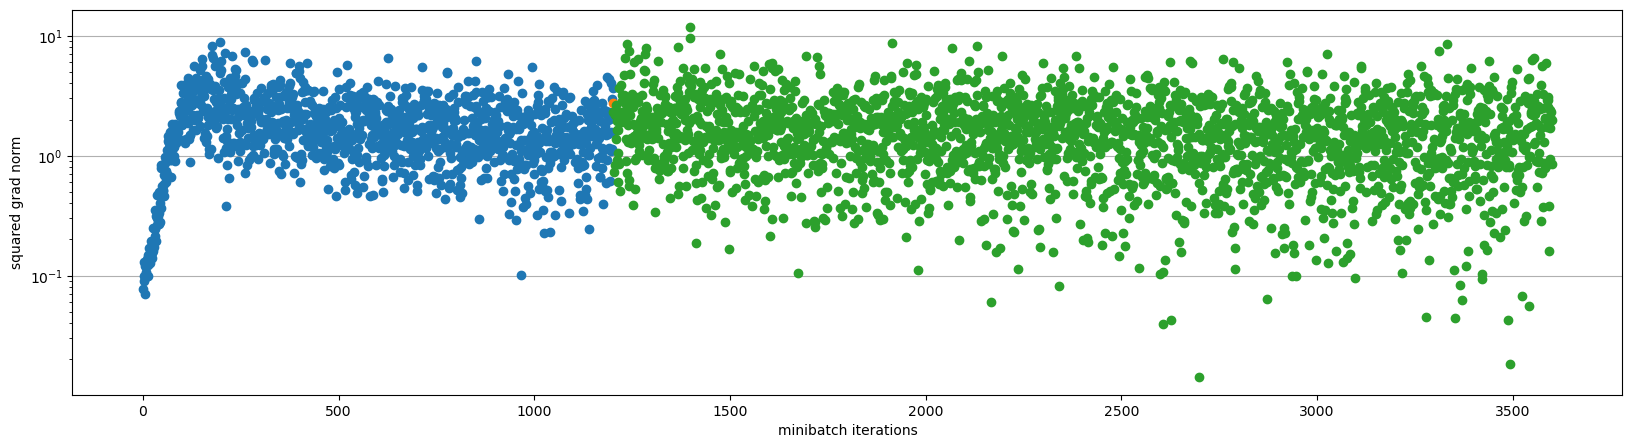

In [15]:
# todo plot
if T1:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(grad_norms1)+1)
    yfull = grad_norms1
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('squared grad norm')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(grad_norms1)))

Text(0.5, 0, 'epochs')

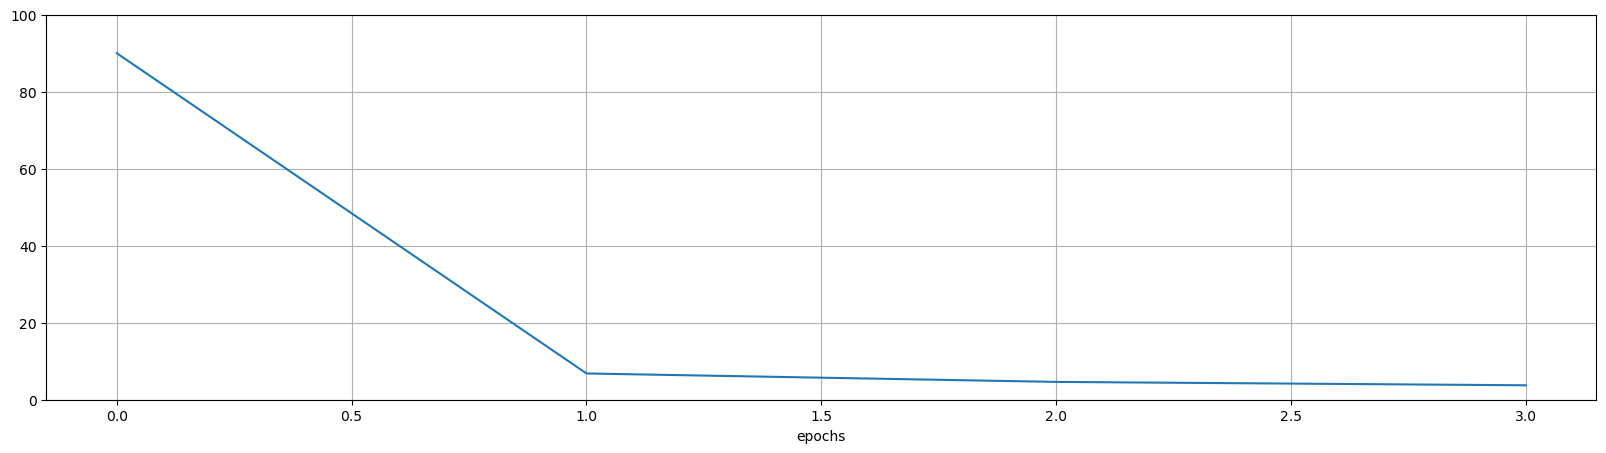

In [16]:
plt.figure(figsize=(20,5))
plt.plot([90.]+test_errors1)#,'o')
plt.ylim(top=100,bottom=0)
plt.grid()
plt.xlabel('epochs')

## Second training

In [17]:
# build net
if _type=='fwd':
    model_init2 = feed_forward(dim_in, dim_out,**kwargs_net)
if _type=='res2':
    model_init2 = two_weight_resnet(dim_in, dim_out,**kwargs_net)
if _type=='res1':
    model_init2 = one_weight_resnet(dim_in, dim_out,**kwargs_net)

torch.nn.utils.vector_to_parameters(param_init, model_init2.parameters())

In [18]:
print(check_testerror(test_dataloader,model_init2))
print(check_testerror(train_dataloader,model_init2))

88.16
88.17166666666667


In [19]:
if T2:
    model2, mb_losses2, test_errors_short2, test_errors2, exit_flag2, grad_norms2 = layer_insertion_loop(
        iters=no_iters,
        epochs=epochs,
        model= model_init2,
        kwargs_net=kwargs_net,
        dim_in=dim_in,
        dim_out=dim_out,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        lr_init=lr_init,
        wanted_test_error=wanted_testerror,
        mode='abs min',#'threshold',
        optimizer_type=optimizer_type,
        lrschedule_type=lrscheduler_type,
        lrscheduler_args=lrscheduler_args,
        check_testerror_between=interval_testerror,
        decrease_after_li=lr_decrease_after_li,
        print_param_flag=False,
        start_with_backtracking=None,
        v2=False,
        save_grad_norms=save_grad_norms
    ) 

starting on 1. net !
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=10, bias=True)
)
tensor(0.0773)
mbloss:  2.2905359268188477
tensor(0.1295)
tensor(0.0990)
tensor(0.0902)
tensor(0.1200)
tensor(0.0701)
tensor(0.1025)
tensor(0.1069)
tensor(0.0980)
tensor(0.1364)
tensor(0.1314)
tensor(0.1496)
tensor(0.0994)
tensor(0.1222)
tensor(0.1336)
tensor(0.1684)
tensor(0.1538)
tensor(0.1523)
tensor(0.1282)
tensor(0.1953)
tensor(0.1659)
tensor(0.1800)
tensor(0.1550)
tensor(0.1412)
tensor(0.1603)
tensor(0.1862)
tensor(0.2484)
tensor(0.1984)
tensor(0.1737)
tensor(0.2423)
tensor(0.3495)
tensor(0.2141)
tensor(0.1938)
tensor(0.3143)
tensor(0.3034)
tensor(0.4705)
tensor(0.2643)
tensor(0.3130)
tensor(0.2813)
tensor(0.3315)
tensor(0.2709)
tensor(0.4977)
tensor(0.2775)
tensor(0.4050)
tensor(0.3625)
tensor(0.8357)
tens

In [20]:
print('test error: ',check_testerror(test_dataloader, model2))
print('train error: ',check_testerror(train_dataloader, model2))

test error:  4.179999999999993
train error:  3.346666666666664


plot results:

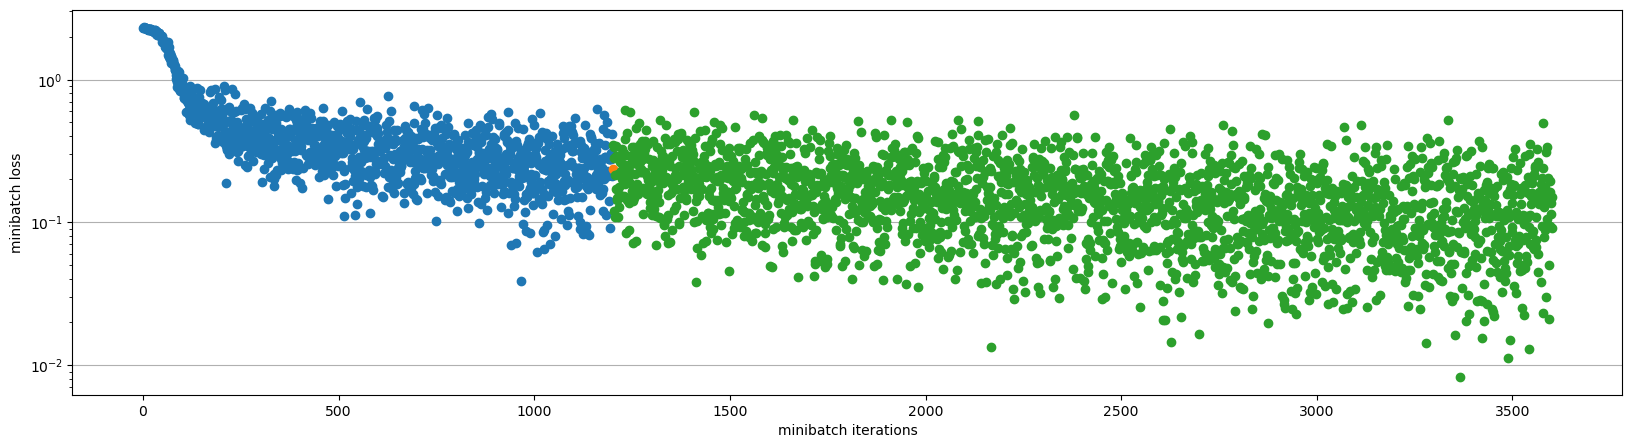

In [21]:
# todo plot
if T2:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(mb_losses2)+1)
    yfull = mb_losses2
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('minibatch loss')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(mb_losses2)))

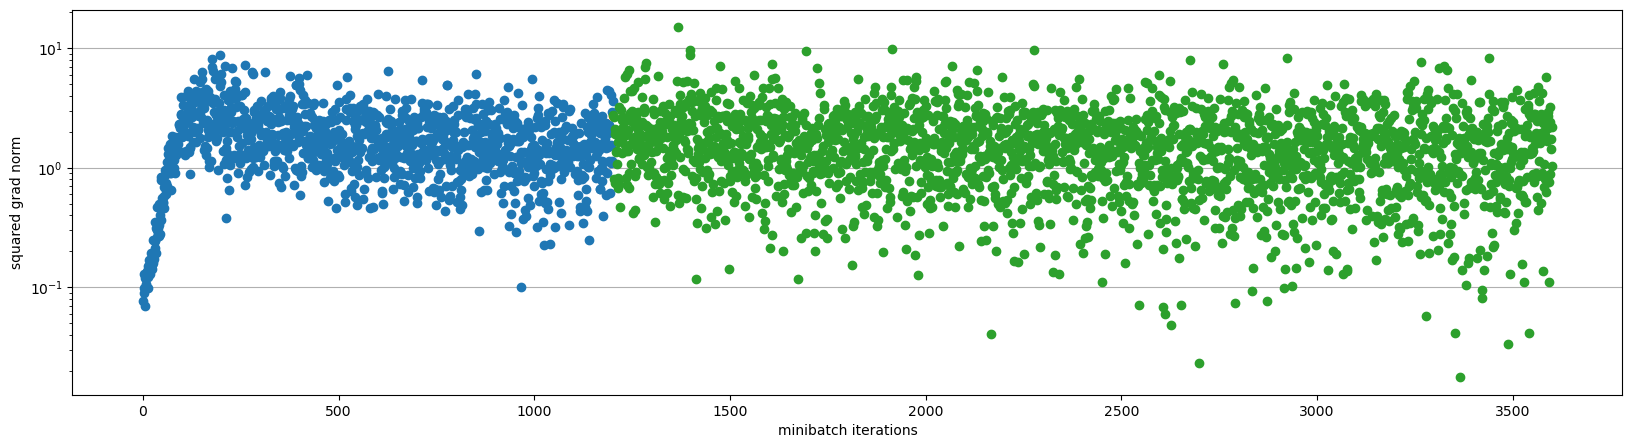

In [22]:
# todo plot
if T2:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(grad_norms2)+1)
    yfull = grad_norms2
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('squared grad norm')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(grad_norms2)))

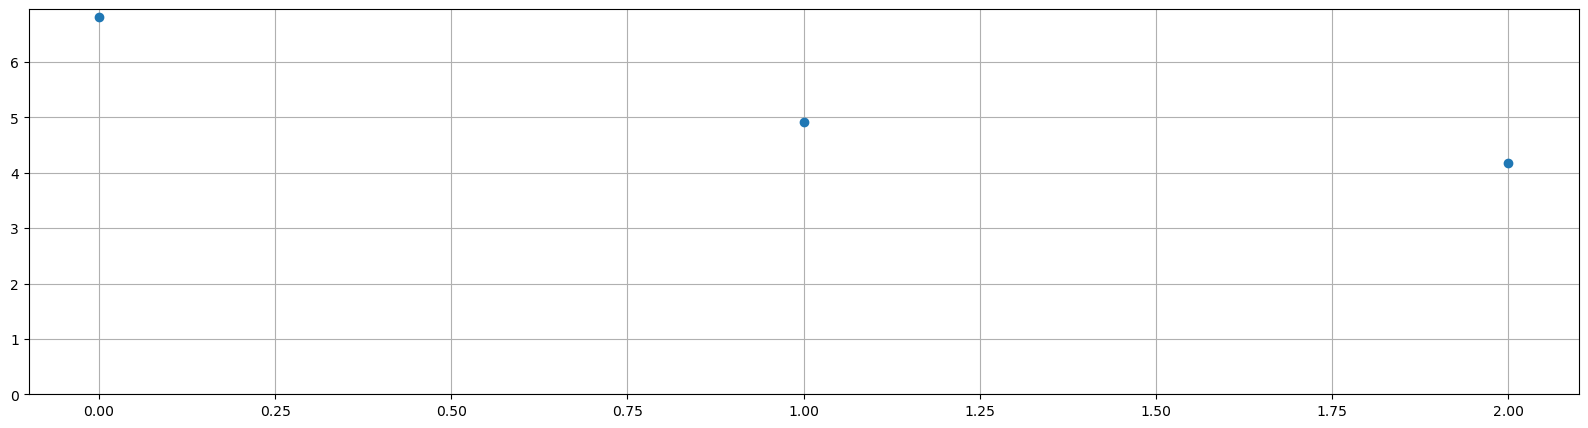

In [23]:
if T2:
    plt.figure(figsize=(20,5))
    #plt.ylim((0,100))
    plt.plot(test_errors2,'o')
    plt.ylim(bottom=0)
    plt.grid()

## Third training

In [24]:
# build model
if _type=='fwd':
    model_classical = feed_forward(dim_in, dim_out,**kwargs_net_classical)
if _type=='res2':
    model_classical = two_weight_resnet(dim_in, dim_out,**kwargs_net_classical)
if _type=='res1':
    model_classical = one_weight_resnet(dim_in, dim_out,**kwargs_net_classical)

torch.nn.utils.vector_to_parameters(param_init_class,model_classical.parameters())

In [25]:
print('test error: ',check_testerror(test_dataloader, model_classical))
print('train error: ',check_testerror(train_dataloader, model_classical))

test error:  88.16
train error:  88.17166666666667


In [26]:
# build optimizer
if optimizer_type == 'SGD':
    optimizer_classical = torch.optim.SGD(model_classical.parameters(), lr_init_classical)
if optimizer_type == 'Adam':
    optimizer_classical = torch.optim.Adam(model_classical.parameters(), lr_init_classical)

# build lr scheduler
if lrscheduler_type == 'StepLR':
    step_size = lrscheduler_args_classical['step_size']
    gamma = lrscheduler_args_classical['gamma']
    lrscheduler_classical = torch.optim.lr_scheduler.StepLR(
            optimizer_classical, step_size=step_size, gamma=gamma)


In [27]:
if T3:
    print('training classically on model', model_classical)
    mblosses_classical, lr_end, test_error_classical, exit_flag_classical, grad_norms_classical = train(model_classical,
                                                             train_dataloader=train_dataloader,
                                                             epochs=epochs_classical,
                                                             optimizer=optimizer_classical,
                                                             scheduler=lrscheduler_classical,
                                                             wanted_testerror=wanted_testerror,
                                                             start_with_backtracking=None,
                                                             check_testerror_between=interval_testerror,
                                                             test_dataloader=test_dataloader,
                                                             print_param_flag=False,
                                                             save_grad_norms=save_grad_norms
                                                             )

training classically on model Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=10, bias=True)
)
tensor(0.0773)
mbloss:  2.2905359268188477
tensor(0.1295)
tensor(0.0990)
tensor(0.0902)
tensor(0.1200)
tensor(0.0701)
tensor(0.1025)
tensor(0.1069)
tensor(0.0980)
tensor(0.1364)
tensor(0.1314)
tensor(0.1496)
tensor(0.0994)
tensor(0.1222)
tensor(0.1336)
tensor(0.1684)
tensor(0.1538)
tensor(0.1523)
tensor(0.1282)
tensor(0.1953)
tensor(0.1659)
tensor(0.1800)
tensor(0.1550)
tensor(0.1412)
tensor(0.1603)
tensor(0.1862)
tensor(0.2484)
tensor(0.1984)
tensor(0.1737)
tensor(0.2423)
tensor(0.3495)
tensor(0.2141)
tensor(0.1938)
tensor(0.3143)
tensor(0.3034)
tensor(0.4705)
tensor(0.2643)
tensor(0.3130)
tensor(0.2813)
tensor(0.3315)
tensor(0.2709)
tensor(0.4977)
tensor(0.2775)
tensor(0.4050)
tensor(0.3625)
tensor(0.8

plot results:

In [28]:
if T3:
    print('test error: ',check_testerror(test_dataloader, model_classical))
    print('train error: ',check_testerror(train_dataloader, model_classical))

test error:  3.8100000000000023
train error:  3.1866666666666674


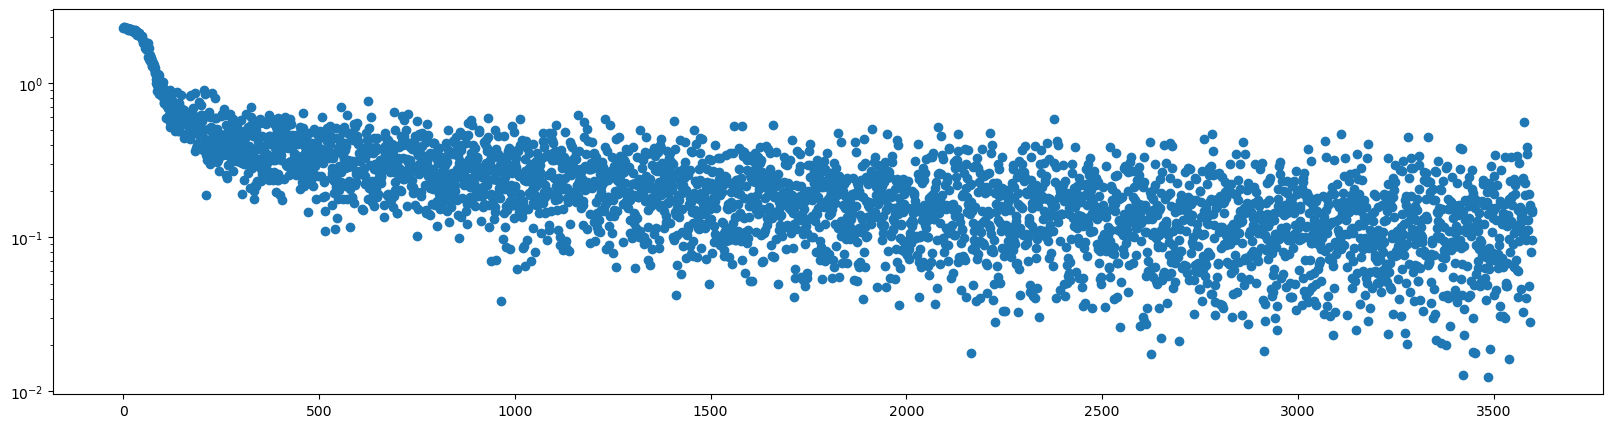

In [29]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot(mblosses_classical,'o')
    plt.yscale('log')
    
    #plt.xlim((-10,3000))
    #plt.ylim((0.68,0.8))

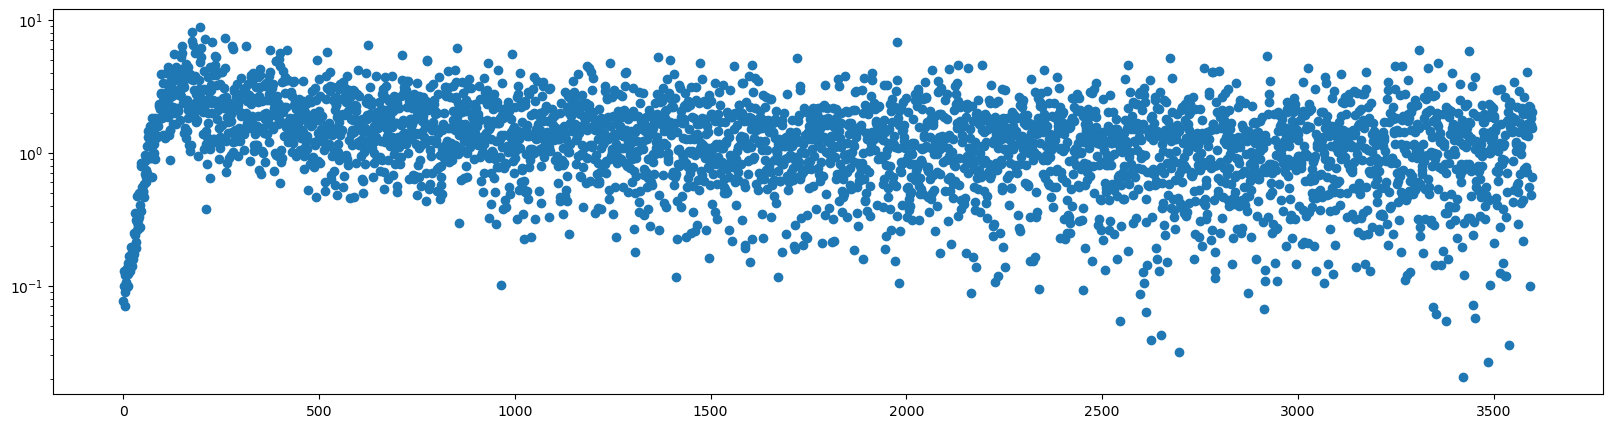

In [30]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot(grad_norms_classical,'o')
    plt.yscale('log')

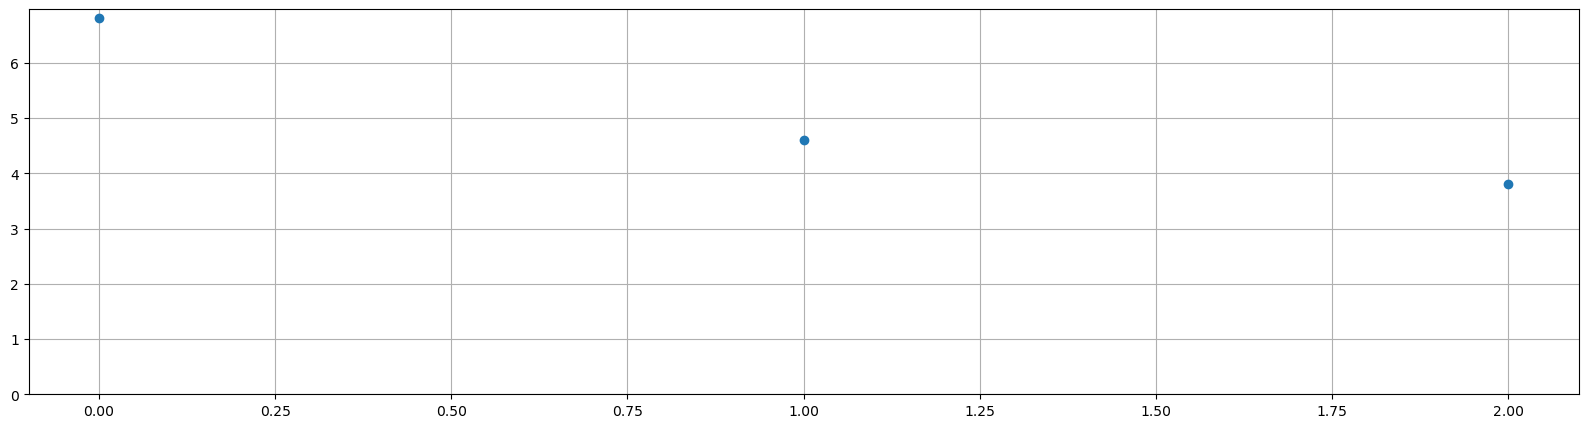

In [31]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot(test_error_classical,'o')
    plt.ylim(bottom=0)
    plt.grid()

## Comparison of the trainings as plot:


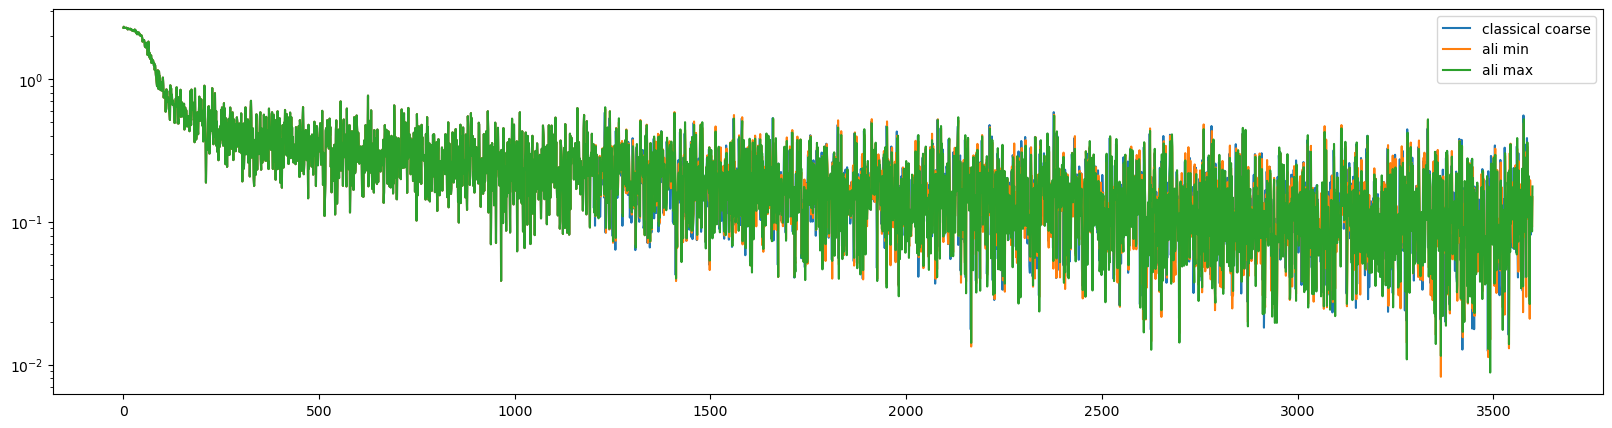

In [32]:
plt.figure(figsize=(20,5))

#if T2:
#    plt.plot(np.zeros(max(len(mb_losses1),len(mb_losses2))))#,len(mblosses_classical))))
if T3:
    plt.plot(mblosses_classical, label='classical coarse')
if T2:
    plt.plot(mb_losses2, label='ali min')
plt.plot(mb_losses1,label='ali max')

plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((80,100))
plt.show()

In [33]:
smooth_factor = 0.9
s1= ema(mb_losses1, smooth_factor)
if T2:
    s2= ema(mb_losses2, smooth_factor)
if T3:
    s3 = ema(mblosses_classical, smooth_factor)

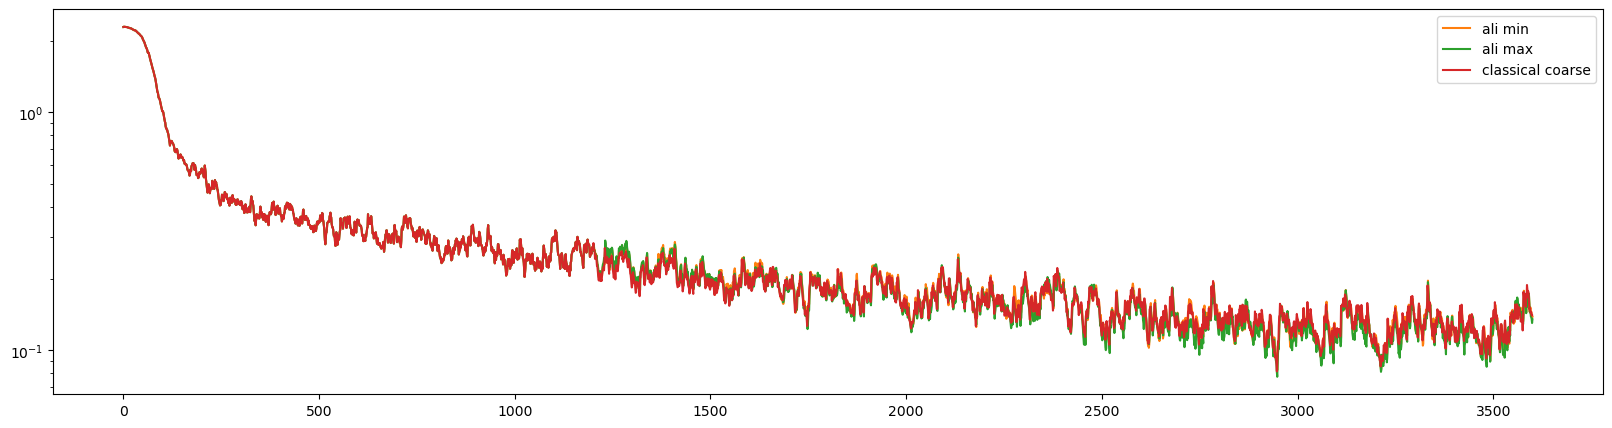

In [34]:
plt.figure(figsize=(20,5))
if T2:
    plt.plot(np.zeros(max(len(s1),len(s2))))#,len(s3))))

if T2:
    plt.plot(s2, label='ali min')
plt.plot(s1,label='ali max')
if T3:
    plt.plot(s3, label='classical coarse')
plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((99800,102000))
plt.show()

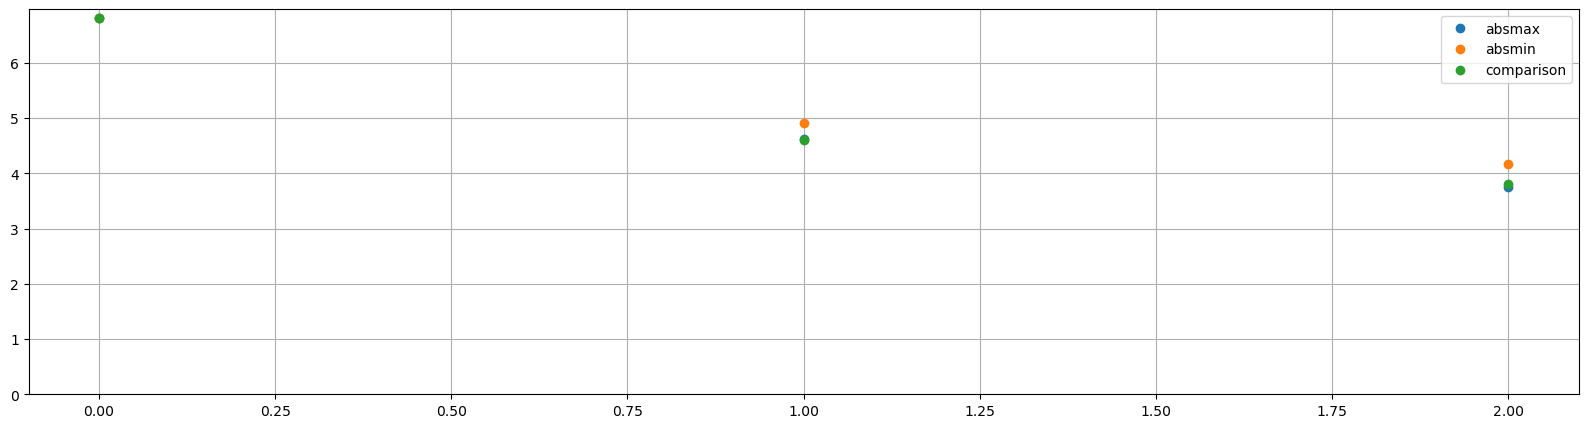

In [35]:
plt.figure(figsize=(20,5))
plt.plot(test_errors1,'o',label='absmax')
if T2:
    plt.plot(test_errors2,'o', label='absmin')
if T3:
    plt.plot(test_error_classical,'o',label='comparison')
plt.grid()
plt.ylim(bottom=0)
plt.legend()